## Inference over a planar robotic arm
### Add the gravity term
This model follows the logic from `run_forced_moving_obj_1D` but with rigid body dynamics for the robotic arm.

Our state-space $\mathbf{x} \in \mathbb{R}^6 $ includes torques $\tau_i$, angles $\theta_i$ and angular velocities $\dot{\theta}_i$. We append all static parameters in $\phi = \{L_{1}, L_{2}, M_{1}, M_{2}\}$.

$$
\mathbf{x} = \begin{pmatrix} \mathbf{x}_1 = \tau_1 \\  \mathbf{x}_2 = \tau_2 \\ \mathbf{x}_3 =\theta_1 \\ \mathbf{x}_4 =\theta_2 \\
\mathbf{x}_5 = \dot{\theta}_1 \\ \mathbf{x}_6 = \dot{\theta}_2 \end{pmatrix}  
$$

$$
\mathbf{\dot{x}} = \begin{pmatrix} 0 \\  0 \\ \mathbf{x}_5 \\ \mathbf{x}_6 \\ \mathbf{D}^{-1}(\mathbf{x}_4, \phi) \begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix}  
\end{pmatrix}  := a(\mathbf{x})
$$

Where $\mathbf{D} \in \mathbb{R}^{2 \times 2}$ is the inertia tensor.

Note that $a(\mathbf{x})$ is non-linear because of the operation $\mathbf{D}^{-1}(\mathbf{x}_4, \phi) \begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix}$.

with noise on the torque

$$
\mathbf{\dot{x}} = a(\mathbf{x}) + \begin{pmatrix} 1 \\ 1 \\ 0 \\ 0\\0\\0\end{pmatrix} \nu, \quad \nu \sim \mathcal{N}(0,1)
$$

with Euler discretizetion 

$$
\mathbf{x}_{t+\Delta{t}} = \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ 0 \\ 0 \\ 0 \\0 \end{pmatrix} \nu_t \approx \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ \sigma \\ \sigma \\ \sigma \\\sigma \end{pmatrix} \nu_t
 $$

where we introduce $\sigma<<\Delta{t}$ to avoid a degenerate distribution.
So our transition is defined as follows:

$$
f(\mathbf{x}_{t+\Delta{t}}|\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_t + \Delta{t}a(\mathbf{x}_t), \text{diag}(\Delta{t}^2,\Delta{t}^2, \sigma, \sigma, \sigma, \sigma))
$$

The emission is 

$$
g(\mathbf{y}_t | \mathbf{x}_t) = \text{FW-KIN}(\mathbf{x}_3, \mathbf{x}_4)
$$

In [1]:
import os
print(os.getcwd())
plot_folder = 'planar_arm_dyn_plots'

/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test


In [2]:
# change dir to import from aesmc
os.chdir("/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc")
import aesmc.statistics as statistics
import aesmc.inference as inference
import aesmc.train as train
import aesmc.losses as losses
import aesmc.state as state
import aesmc.math as math

In [3]:
# change dir to import from aesmc/test
os.chdir("/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test")
from arm_models import planar_arm_dyn_model # the model script -- distribution objects are defined there
from arm_models import arm_utils # make video, plot post, params to coords
from arm_models import utils_summary
from arm_models import fw_sim_planar_arm_dyn

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [5]:
# matplotlib general settings 
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

mpl.rcParams['lines.linewidth'] = 4.0

In [6]:
import pickle
import numpy as np

# pickle utils
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def load_object(filename):
    with open(filename, 'rb') as input: # note rb and not wb
        return pickle.load(input)

In [7]:
# define global model params
dt = 0.03
g = 0
dim_latents = 6 # always 6 in this model.
dim_obs = 4
transition_force_scale = 20.0 # was best # tried also 10, 30, 50
transition_aux_scale = ((dt**2)*transition_force_scale**2) / (10.0) #* 2
initial_loc = 0.0
initial_scale = 0.5 # in future could be different per dimension.
emission_var_diag = 0.1 # this varies with the application. 
# it was working relatively well with 0.2 or 1.0 for linear case. but for the arm it's to big.
print('torque effective variance: %.5f' %((dt**2)*transition_force_scale**2))
print('auxilliary variance: %.5f' % transition_aux_scale)

torque effective variance: 0.36000
auxilliary variance: 0.03600


In [8]:
# put params into dicts
param_dict = {}
param_dict["init_mu"] = initial_loc * np.ones(dim_latents)
param_dict["init_cov"] = np.eye(dim_latents) * initial_scale
#param_dict["C"] = np.eye(dim_obs) # (1.0/6.0)*np.random.normal(size = (dim_obs,dim_latents))
param_dict["C"] = np.zeros(
    (dim_obs, dim_latents))  # not good, change, np.eye(dim_obs) #
print(type(param_dict["C"]))
param_dict["C"] = np.array(([[0, 0, 1.0, 0, 0, 0], [0, 0, 0, 1.0, 0, 0],
                             [0, 0, 0, 0, 1.0, 0], [0, 0, 0, 0, 0, 1.0]]))
print(param_dict["C"])
#param_dict["C"][0,2] = 1.0 # if select just a couple of states, config that here.
#param_dict["C"][1,3] = 1.0 # if select just a couple of states, config that here.
#param_dict["C"][2,4] = 1.0 # if select just a couple of states, config that here.
#param_dict["C"][3,5] = 1.0 # if select just a couple of states, config that here.
param_dict["R"] = np.eye(dim_obs) * emission_var_diag
inits_dict = {}
inits_dict["L1"] = 2.0
inits_dict["L2"] = 2.0
inits_dict["M1"] = 1.1
inits_dict["M2"] = 1.2

<class 'numpy.ndarray'>
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [9]:
# running params
num_timesteps = 200
saving_interval = 10
logging_interval = 10
batch_size = 10
num_iterations = 500
num_particles = 1000

In [10]:
# initialize arm model, used by transition and proposal.
arm_model_instance = planar_arm_dyn_model.PlanarArmDyn(dt, inits_dict, g)

In [11]:
# ToDo: consider using observations to initialize properly.
initial = planar_arm_dyn_model.Initial(param_dict["init_mu"],
                                       param_dict["init_cov"])
transition = planar_arm_dyn_model.Transition_Short(dt, transition_force_scale,
                                                   transition_aux_scale,
                                                   arm_model_instance)
emission = planar_arm_dyn_model.Emission_Linear(param_dict["C"],
                                                param_dict["R"])

In [12]:
# BPF -- working well
#proposal = planar_arm_dyn_model.Bootstrap_Proposal_Short( \
#                                initial, transition)
# Optimal proposal -- working 
proposal = planar_arm_dyn_model.Optimal_Proposal(initial, transition, emission)

In [13]:
np.random.seed(0)
torch.manual_seed(0)

In [14]:
sim_lats , sim_observs = statistics.sample_from_prior(initial,
                                transition,
                                emission, 
                                num_timesteps,
                                batch_size)
print(sim_lats[-1].size()) # [batch_size, dim_latents]
print(sim_observs[-1].size()) # [batch_size, dim_obs]

torch.Size([10, 6])
torch.Size([10, 4])


In [28]:
# simulate data from full model with forward kin. 
emission = planar_arm_dyn_model.Emission(inits_dict,
                                np.eye(6)*emission_var_diag)

In [29]:
sim_lats , sim_observs = statistics.sample_from_prior(initial,
                                transition,
                                emission, 
                                num_timesteps,
                                batch_size)
print(sim_lats[-1].size()) # [batch_size, dim_latents]
print(sim_observs[-1].size()) # [batch_size, dim_obs]

torch.Size([10, 6])
torch.Size([10, 6])


In [30]:
# # if simulating from a deterministic model.
# sim_lats , sim_observs = fw_sim_planar_arm_dyn(
# sim_data(dt, num_timepoints, 
#                  param_dict, inits_dict, 
#                  sin_amp, sin_omega,
#                  sin_phase_diff, plot = True)  
# )
# print(sim_lats[-1].size()) # [batch_size, dim_latents]
# print(sim_observs[-1].size()) # [batch_size, dim_obs]

In [31]:
# concatenate and convert to numpy.
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
print(lat_data.shape) # [batch_size, dim_latents, num_timesteps]
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2)
print(sim_data.shape)
lat_data_np = lat_data.detach().numpy()
sim_data_np = sim_data.detach().numpy()

torch.Size([10, 6, 200])
torch.Size([10, 6, 200])


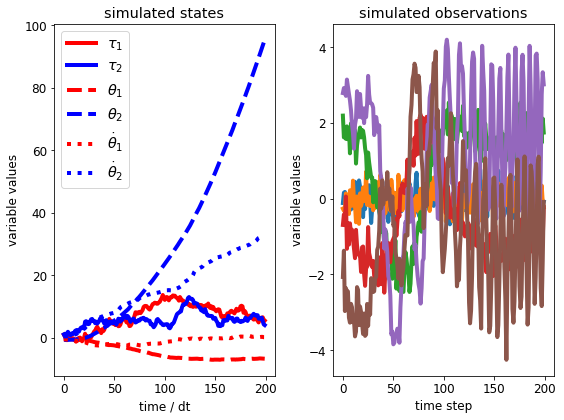

In [32]:
ind_in_batch = 9  # could be between 0 and batch_size-1
plt.subplot(121)
plt.plot(lat_data[ind_in_batch, 0, :].detach().numpy(),
         'red',
         label=r"$\tau_1$")
plt.plot(lat_data[ind_in_batch, 1, :].detach().numpy(),
         'blue',
         label=r"$\tau_2$")
plt.plot(lat_data[ind_in_batch, 2, :].detach().numpy(),
         'red',
         linestyle="dashed",
         label=r"$\theta_1$")
plt.plot(lat_data[ind_in_batch, 3, :].detach().numpy(),
         'blue',
         linestyle='dashed',
         label=r"$\theta_2$")
plt.plot(lat_data[ind_in_batch, 4, :].detach().numpy(),
         'red',
         linestyle="dotted",
         label=r"$\dot{\theta}_1$")
plt.plot(lat_data[ind_in_batch, 5, :].detach().numpy(),
         'blue',
         linestyle='dotted',
         label=r"$\dot{\theta}_2$")
# plt.plot(sim_data[ind_in_batch,0,:].detach().numpy(), 'black',
#           label = r"$y_1 =  \theta_1 + \epsilon$", linestyle = 'dashdot');#plt.plot(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'gray'); # 0! it's also not on the same scale
# plt.plot(sim_data[ind_in_batch,1,:].detach().numpy(), 'black',
#           label = r"$y_2 =  \theta_2 + \epsilon$", linestyle = ':');
plt.title('simulated states')
plt.ylabel('variable values')
plt.xlabel('time / dt')
plt.legend()
plt.subplot(122)
plt.plot(sim_data_np[ind_in_batch, :, :].T)
plt.title('simulated observations')
plt.ylabel('variable values')
plt.xlabel('time step')
plt.tight_layout()
plt.savefig(plot_folder + '/sim_data_vis.png')

## suggested pipeline
1. simulate data from full model - `Transition_Short` + `Emission`.
2. pre-process: infer using - `Transition_Velocity` + `Emission` + `Bootstrap_Proposal`.
3. take the mean infered states $\mathbf{x} \in \mathbb{R}^4$ as observations, and infer using `Transition_Short` + `Emission_Linear` + 'Optimal_Proposal`.

In [18]:
import time as time
start_time_fw = time.time()
inference_result = inference.infer(
            inference_algorithm='smc',
            observations=sim_observs, 
            initial=initial,
            transition=transition,
            emission=emission,
            proposal=proposal,
            num_particles=num_particles,
            return_log_weights=True,
        )
print('run time for %i timesteps, %i batches, %i particles = %.2f' % \
      (num_timesteps, batch_size, 
       num_particles, time.time() - start_time_fw))

run time for 200 timesteps, 10 batches, 1000 particles = 13.59


In [19]:
posterior_summary = utils_summary.summarize_posterior(inference_result)

In [20]:
label_list = [r'$\tau_1$', r'$\tau_2$', 
              r'$\theta_1$', r'$\theta_2$',
             r'$\dot{\theta}_1$', r'$\dot{\theta}_2$']

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


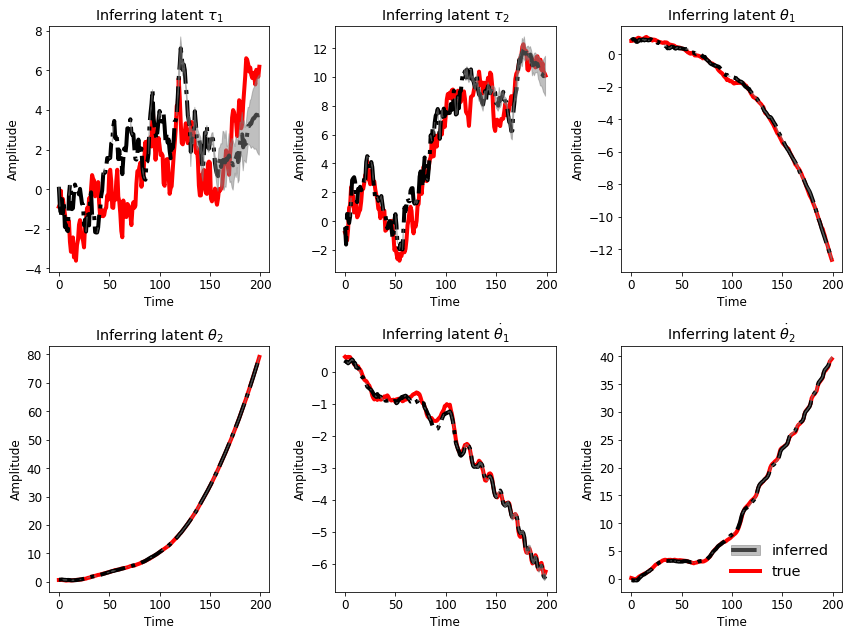

In [21]:
ind_in_batch = 6
fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(posterior_summary["smooth_mean"].shape[1]):
    if i == 5:
        plt_leg = True
    arm_utils.plot_posterior_trace(
        post_mean=posterior_summary["smooth_mean"][ind_in_batch, i, :],
        post_var=np.sqrt(posterior_summary["smooth_var"][ind_in_batch, i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_list[i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
fig.tight_layout()
plt.savefig(plot_folder + '/OP_infer_latents.png')

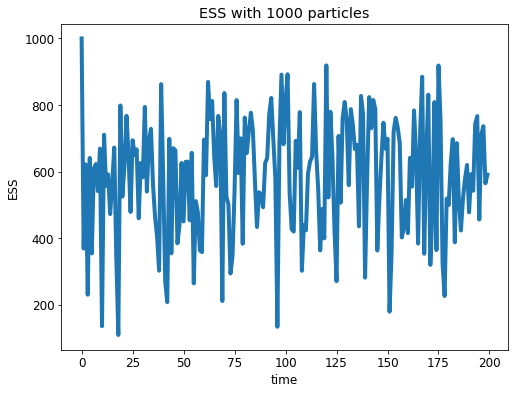

In [22]:
# plot ESS
plt.plot(posterior_summary["ESS"][ind_in_batch,:])
plt.xlabel('time')
plt.ylabel('ESS')
plt.title('ESS with %i particles' % num_particles);
plt.savefig(plot_folder+'/ESS_2_1.png')

In [23]:
# only for linear case!!
preds = np.zeros((dim_obs, num_timesteps))
preds_low = np.zeros((dim_obs, num_timesteps))
preds_high = np.zeros((dim_obs, num_timesteps))
for t in range(posterior_summary["smooth_mean"].shape[-1]):
    preds[:,t] = np.matmul(
                param_dict["C"],
                posterior_summary["smooth_mean"][ind_in_batch,:,t])
    preds_low[:,t] = np.matmul(
                param_dict["C"],
                posterior_summary["smooth_mean"][ind_in_batch,:,t]-
                np.sqrt(posterior_summary["smooth_var"][ind_in_batch,:,t]))
    preds_high[:,t] = np.matmul(
                param_dict["C"],
                posterior_summary["smooth_mean"][ind_in_batch,:,t]+
                np.sqrt(posterior_summary["smooth_var"][ind_in_batch,:,t]))

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


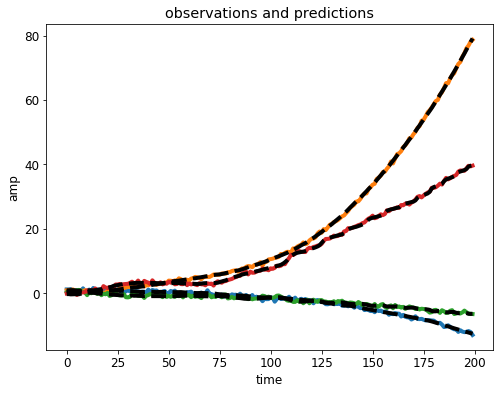

In [24]:
# only for linear case
plt.plot(sim_data_np[ind_in_batch,:,:].T);
plt.plot(preds[:,:].T, 'k--');
plt.xlabel('time')
plt.ylabel('amp')
#plt.legend(['obs', 'predictions'])
plt.title('observations and predictions')
plt.savefig(plot_folder +'/pred_vs_obs.png')

In [55]:
#multiple runs on the same data
num_runs = 10
inference_result = []
for run in range(num_runs):
    inference_result.append(
        inference.infer(
                inference_algorithm='smc',
                observations=sim_observs, 
                initial=initial,
                transition=transition,
                emission=emission,
                proposal=proposal,
                num_particles=num_particles,
                return_log_weights=True,
            )
    )

In [80]:
posterior_summary = []
for run in range(num_runs):
    posterior_summary.append(
        utils_summary.summarize_posterior(
        inference_result[run])
    )
save_object(posterior_summary, 'post_summary_OP_10_runs')

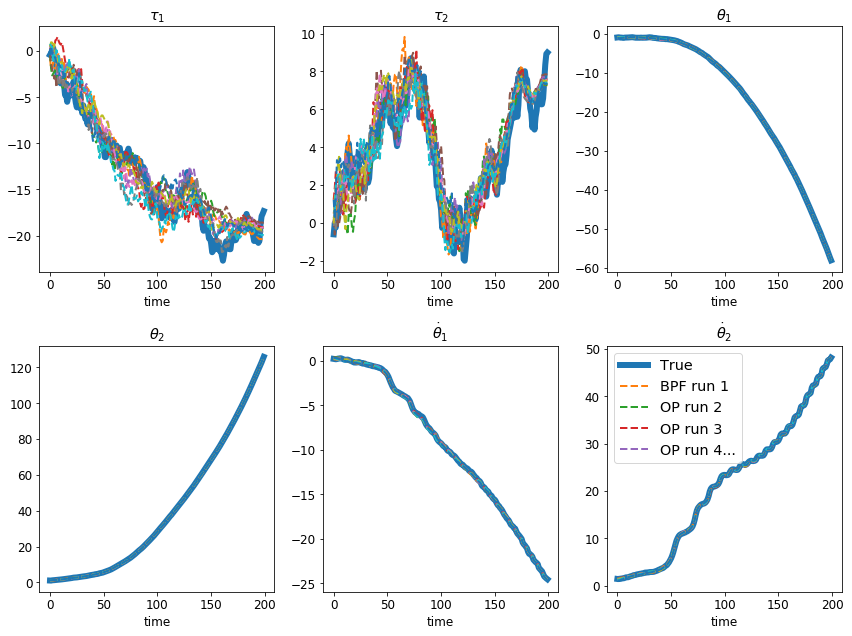

In [44]:
# first loop over latents 
# NOTE -- OP OR BPF? use currect legend and name
ind_in_batch = 1
fig, axs = plt.subplots(2, 3, figsize=(12, 9), 
                        sharey = False)
axs = axs.flatten()
for i in range(posterior_summary[0]["smooth_mean"].shape[1]):
    axs[i].plot(lat_data_np[ind_in_batch,i,:], linewidth = 6.0)
    axs[i].set_title(label_list[i])
    axs[i].set_xlabel("time")
    for run in range(num_runs):
        axs[i].plot(
            posterior_summary[run]["smooth_mean"][ind_in_batch,i,:],
            linestyle = 'dashed', linewidth = 2)
    axs[-1].legend(["True", "BPF run 1", 
                    "OP run 2", 
                    "OP run 3", 
                    "OP run 4..."])
fig.tight_layout()
plt.savefig(plot_folder+'/OP_multiple_runs.png')


In [65]:
sim_data.shape

torch.Size([10, 4, 200])

In [28]:
## if simulate all the way forward to coords.
#x_obs = sim_data_np[ind_in_batch, [0,2,4], :].T
#y_obs = sim_data_np[ind_in_batch, [1,3,5], :].T
## if simulate only to angles and velocities.
x_obs, y_obs = arm_utils.coords_from_params_mat(
   sim_data[ind_in_batch,0,:], 
    sim_data[ind_in_batch,1,:], 
                inits_dict["L1"], inits_dict["L2"]) 
print(y_obs.shape)

(200, 3)


In [29]:
# TODO: make sure to input right params for learning
x_hat , y_hat = arm_utils.coords_from_params_mat(
   posterior_summary["smooth_mean"][ind_in_batch,2,:], 
    posterior_summary["smooth_mean"][ind_in_batch,3,:], 
                inits_dict["L1"], inits_dict["L2"]) 
x_hat.shape

(200, 3)

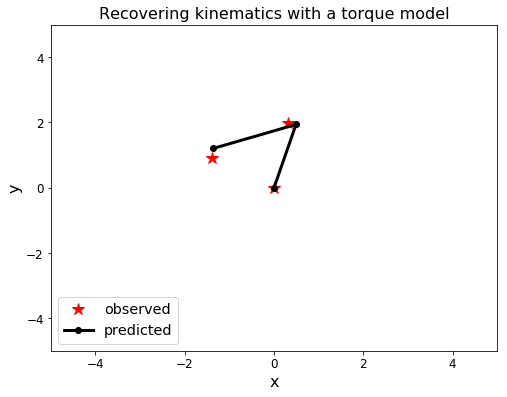

In [30]:
arm_utils.video_sim_plane_2D(x_obs, y_obs, 
                             x_hat, y_hat, 
                             plot_folder+'/recover_dyn', 
                   "Recovering kinematics with a torque model", 
                             x_hat.shape[0], inits_dict["L1"] + 
                             inits_dict["L2"] + 1)

In [70]:
# the optimal prop
def compute_average_ESS(posterior_summary_list, batch_size):
    mean_ess = np.zeros((len(posterior_summary_list), batch_size))
    for i in range(len(posterior_summary_list)): # i indicates run
        for b in range(batch_size): # b indicates batch of data (same across runs)
            mean_ess[i,b] = np.mean(posterior_summary_list[i]["ESS"][b,:]) # average over time
    return mean_ess

In [85]:
OP_summary = load_object('post_summary_OP_10_runs')
BPF_summary = load_object('post_summary_BPF_10_runs')
mean_ess_OP = compute_average_ESS(OP_summary, batch_size)
mean_ess_BPF = compute_average_ESS(BPF_summary, batch_size)

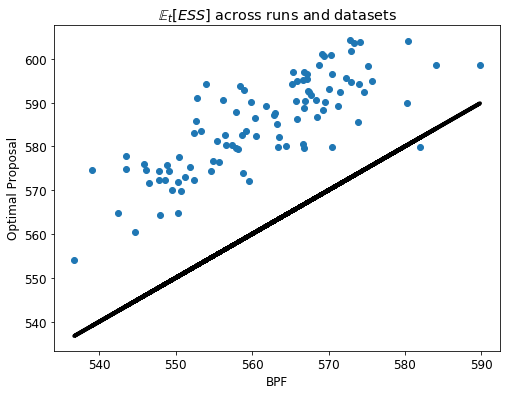

In [95]:
plt.scatter(mean_ess_BPF.flatten(),mean_ess_OP.flatten())
plt.plot(mean_ess_BPF.flatten(), mean_ess_BPF.flatten(), 'k')
plt.xlabel('BPF')
plt.ylabel('Optimal Proposal')
plt.title(r'$\mathbb{E}_{t}[ESS]$' + ' across runs and datasets')
plt.savefig(plot_folder +'/ESS_comparison.png')

In [32]:
def expand_normalize_weights(weight_tensor, k_realizations):
    '''seems to only be needed at step T. 
        Args: 
            weight_tensor: torch.tensor([batch_size, num_particles])
            k_realizations: integer that says how many smoothing realizations we need
        Returns:
             torch.tensor([k_realizations, batch_size, num_particles])
             repetitions across dim0, and all the particles (dim2) are summed to 1.
            '''
    expanded_weights = weight_tensor.unsqueeze(0). \
            expand(k_realizations, \
                   weight_tensor.shape[0], \
                   weight_tensor.shape[1]) 
    normalized_weights = math.exponentiate_and_normalize(
            expanded_weights.detach().cpu().numpy(), \
                dim=2) # dimension of particles
    
    return torch.tensor(normalized_weights)

In [81]:
# one issue is that weights at time 0 are all uniform = 0.001 for some reason. will have
# to check. maybe undeflow issues when adding log probs.

In [33]:
def expand_chosen_particles(chosen_particles, num_particles):
    '''in: torch.Size([k_realizations, batch_size, dim_latents]), num_particles in PF
        out: torch.Size([k_realizations, batch_size, num_particles, dim_latents])
        where we repeat across dim = -2'''
    return chosen_particles.unsqueeze(-2).expand(
            chosen_particles.shape[0],
            chosen_particles.shape[1],
            num_particles, 
            chosen_particles.shape[2])

In [34]:
def weight_update(chosen_particles_tplus1, 
                  filtered_latents_t, 
                 log_weights_filtering_t,
                 transition_object):
    '''exapnd particles from step t+1, so that we can evaluate
    their log probability under the transition (which is expanded
    with num_particles). then add the log probability under transition
    to the log weights from filtering. exponentiate and normalize weights.'''
    latents_expanded = expand_chosen_particles(
        latents, filtered_latents_t.shape[1]) # \tilde{x}_{t+1} expanded
    lp_trans = transition_object(
                [filtered_latents_t]).log_prob(
                latents_expanded) # f(\tilde{x}_{t+1}|x_t)
    w_t_given_tplus1 = log_weights_filtering_t + \
                        lp_trans 
    # broadcasting above, result is 
    # torch.Size([k_realizations, batch_size, num_particles])
    normalized_weights = torch.tensor(math.exponentiate_and_normalize(
                w_t_given_tplus1.detach().cpu().numpy(), dim=2))
    return normalized_weights

In [35]:
def sample_latents(normalized_weights, filtered_latents_t):
    '''normalized_weights: 
            torch.Size([k_realizations, batch_size, num_particles])
        filtered_latents_t:
            torch.Size([batch_size, num_particles, dim_latents])'''
    # ranomly choose indices
    sampled_indices = torch.distributions.Categorical(
                        normalized_weights).sample()
    # get associated latents
    latents = filtered_latents_t[np.tile(
            np.arange(normalized_weights.shape[1]),
            (normalized_weights.shape[0],1)), 
                sampled_indices, :]
    return sampled_indices, latents

In [37]:
def expand_distribution_obj(dist, k_realizations):
    '''assumes a multivariate normal distribution here
    maybe no need for that. I see that it gives the same results'''
    expanded_loc = dist.loc.unsqueeze(0).expand(k_realizations,
                                                dist.loc.shape[0],
                                                dist.loc.shape[1],
                                                dist.loc.shape[2])
    expanded_cov = dist.covariance_matrix.unsqueeze(0).expand(
        k_realizations, dist.covariance_matrix.shape[0],
        dist.covariance_matrix.shape[1], dist.covariance_matrix.shape[2],
        dist.covariance_matrix.shape[3])
    return torch.distributions.MultivariateNormal(
        loc=expanded_loc, covariance_matrix=expanded_cov)

In [38]:
# tested with functions. it works.
# ToDo: consider building a class that does that.
# give it the inference results and desired K realizations and it'll
# do everything.
k_realizations = 200
smoothing_result = {}  # dict of lists
smoothing_result["normalized_weights"] = []
smoothing_result["latents"] = []
smoothing_result["sampled_indices"] = []

for t in range(num_timesteps - 1, -1, -1):
    if t == num_timesteps - 1:
        normalized_weights = expand_normalize_weights(
            inference_result["log_weights"][-1],
            k_realizations)  # Note index -1
        sampled_indices, latents = sample_latents(
            normalized_weights, inference_result["latents"][-1])
    else:
        # compute weights
        normalized_weights = weight_update(latents,
                                           inference_result["latents"][t],
                                           inference_result["log_weights"][t],
                                           transition)

        sampled_indices, latents = sample_latents(
            normalized_weights, inference_result["latents"][t])

    # these lists will all be flipped in time
    smoothing_result["normalized_weights"].append(normalized_weights)
    smoothing_result["latents"].append(latents)
    smoothing_result["sampled_indices"].append(sampled_indices)

In [39]:
# flip order
smoothing_result["normalized_weights"] = smoothing_result["normalized_weights"][::-1]
smoothing_result["latents"] = smoothing_result["latents"][::-1]
smoothing_result["sampled_indices"] = smoothing_result["sampled_indices"][::-1]

In [40]:
smoothing_result["latents"][-1].shape
posterior_summary["smooth_mean"].shape

(10, 6, 200)

In [41]:
smooth_traj = torch.cat([smooth.unsqueeze(-1) for
                           smooth in smoothing_result["latents"]], dim=3)
smooth_mean = torch.mean(smooth_traj, dim=0).detach().numpy() # over trajectories
smooth_var = torch.var(smooth_traj, dim=0).detach().numpy()

In [42]:
smooth_mean.shape
smooth_var.shape

(10, 6, 200)

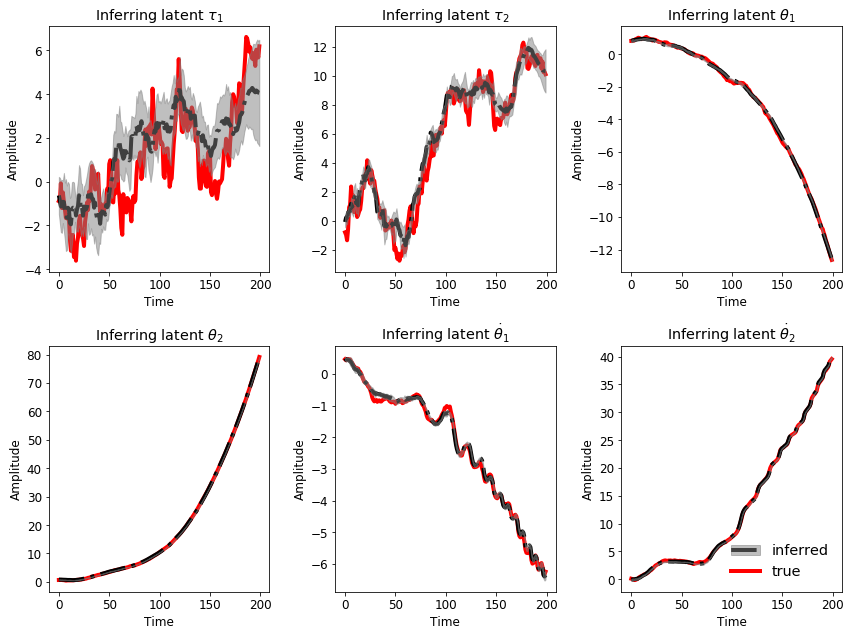

In [48]:
ind_in_batch = 6
fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharey = False)
axs = axs.flatten()
plt_leg = False
for i in range(posterior_summary["smooth_mean"].shape[1]):
    if i ==5:
        plt_leg = True
    arm_utils.plot_posterior_trace(
                    post_mean = smooth_mean[ind_in_batch,i,:], 
                     post_var =  np.sqrt(smooth_var[ind_in_batch,i,:]), 
                     data_vec = lat_data_np[ind_in_batch,i,:], 
                     alpha = 0.5, plot_legend=plt_leg, 
                     plot_uncertainty=True, plot_true_data=True, 
                     legends_list = ["inferred",
                                        "true"], 
                     legend_loc = "lower right", 
                         title = "Inferring latent " + label_list[i] , 
                     xlabel = 'Time', ylabel = 'Amplitude', fig_fullname = None, 
                     ax = axs[i]);
fig.tight_layout()
plt.savefig(plot_folder+'/FFBS_OP_infer_latents.png')


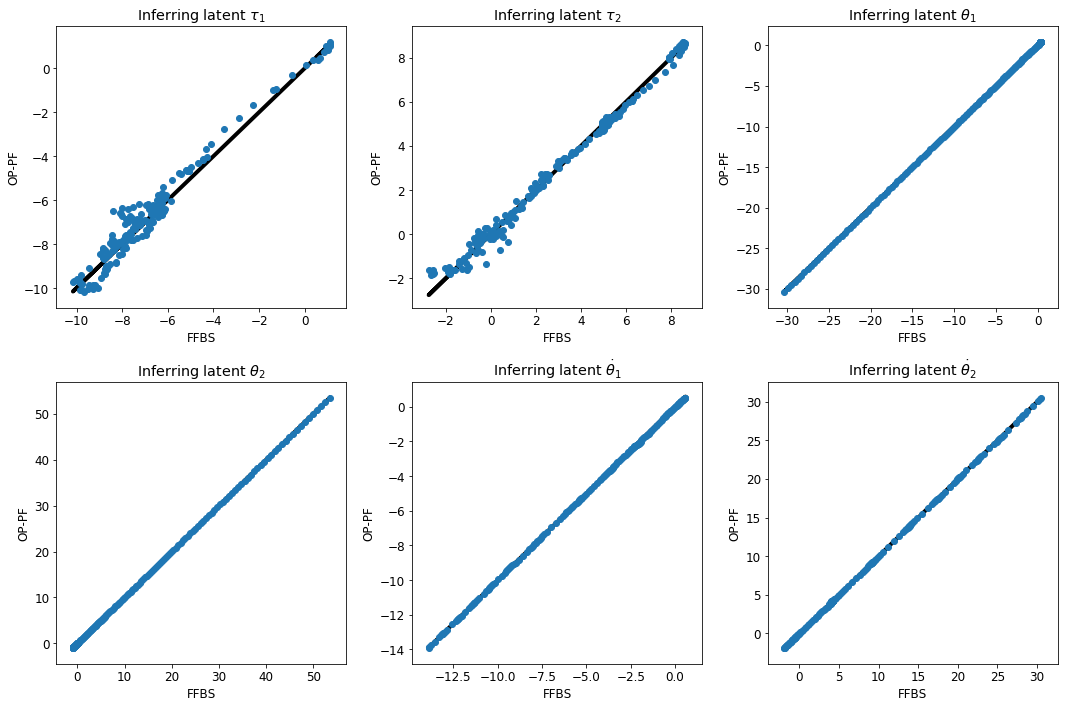

In [46]:
titles = ['$x_{1}$', '$x_{2}$']
plt_leg = False
nrows = 2
fig, axs = plt.subplots(nrows,int(posterior_summary["smooth_mean"].shape[1]/nrows), 
                        figsize = (15,10), sharey=False)
axs = axs.flatten()
for i in range(posterior_summary["smooth_mean"].shape[1]):
    
    if i == 0:
        label = '$x_{1} = f$'
    elif i == 1:
        label = '$x_{2} = x$'
    elif i == 2:
        label = '$x_{3} = \dot{x}$'
        plt_leg = True
    
    axs[i].plot(smooth_mean[ind_in_batch,i,:], 
                smooth_mean[ind_in_batch,i,:], 'k') # diag line
    axs[i].scatter(smooth_mean[ind_in_batch,i,:], 
            posterior_summary["smooth_mean"][ind_in_batch,i,:], 
                   zorder=3)
    axs[i].set_xlabel('FFBS')
    axs[i].set_ylabel('OP-PF')
#     axs[i].plot(filtered_state_means[:,i], color = 'black', linestyle = 'dotted', 
#                 label = 'Kalman filter');
    axs[i].set_title("Inferring latent " + label_list[i])

fig.tight_layout()
plt.savefig(plot_folder+'/compare_FFBS_OPPF.png')

In [259]:
expanded_dist = expand_distribution_obj(transition([inference_result["latents"][-2]]), k_realizations)
lp1 = expanded_dist.log_prob(res)

In [260]:
lp1.shape

torch.Size([3, 10, 1000])

In [268]:
print(transition([inference_result["latents"][-2]]))
lp2 = transition([inference_result["latents"][-2]]).log_prob(res)
print((lp1 == lp2).detach().numpy().all())
lp2.shape

MultivariateNormal(loc: torch.Size([10, 1000, 6]), covariance_matrix: torch.Size([10, 1000, 6, 6]))
True


torch.Size([3, 10, 1000])

In [217]:
k_realizations = 3
# time = T
normalized_weights = math.exponentiate_and_normalize( # normalize weights
        inference_result["log_weight"].detach().cpu().numpy(), dim=1)
cat_dist = torch.distributions.Categorical(torch.tensor(normalized_weights)) # define a Categorical distribution
sampled_indices = cat_dist.sample((k_realizations,)) # sample indices
particles_T = inference_result["latents"][-1][np.tile( # get the particles
        np.arange(batch_size),(k_realizations,1)
        ), sampled_indices, :] # torch.Size([k_realizations, batch_size, dim_latents])
expanded_full= particles_T.view(3,batch_size,1,6).expand(3,batch_size, num_particles, 6)



In [228]:
# assuming k_realizations = 0 for now (loop over k's). expand to eval probability under transition
expanded = particles_T[0, :, :].view(batch_size,1,6).expand(batch_size, num_particles, 6)
#transition([inference_result["latents"][-2]])
transition_log_prob = state.log_prob(
            transition([inference_result["latents"][-2]]),
            expanded)
w_t_given_tplus1 = inference_result["log_weights"][-2] + \
        transition_log_prob # log(a*b) = loga + logb; log scale, unnormalized
normalized_weights = math.exponentiate_and_normalize( # normalize weights
        w_t_given_tplus1.detach().cpu().numpy(), dim=1) # make sure dimension is correct - dimension of particles.
# choose \tilde{x}_t using the normalized weights.
# can replace with updated version
cat_dist = torch.distributions.Categorical(torch.tensor(normalized_weights)) # define a Categorical distribution
sampled_indices = cat_dist.sample((k_realizations,)) # sample indices
particles_Tminus1 = inference_result["latents"][-2][np.tile( # get the particles
        np.arange(batch_size),(k_realizations,1)
        ), sampled_indices, :]

In [229]:
# first we loop over time
# inside we loop over trajectories when needed. which is in evaluating probability
# how can we overcome that? maybe expand the output of transition?
norm_expanded = torch.tensor(normalized_weights).view(1,10,1000).expand(3,10,1000)
cat_dist = torch.distributions.Categorical(norm_expanded) # define a Categorical distribution
torch.manual_seed(0)
sampled_indices = cat_dist.sample() # = cat_dist.sample()
print(sampled_indices.shape)
norm_expanded = torch.tensor(normalized_weights)
cat_dist1 = torch.distributions.Categorical(norm_expanded) # define a Categorical distribution
torch.manual_seed(0)
sampled_indices1 = cat_dist1.sample((3,))
print(sampled_indices1.shape)

torch.Size([3, 10])
torch.Size([3, 10])


In [230]:
print(cat_dist)
print(cat_dist1)
print(cat_dist.probs[:,4,4])
print(cat_dist1.probs[4,4])
print(sampled_indices.squeeze(0) == sampled_indices1)

Categorical(probs: torch.Size([3, 10, 1000]))
Categorical(probs: torch.Size([10, 1000]))
tensor([5.7876e-28, 5.7876e-28, 5.7876e-28], dtype=torch.float64)
tensor(5.7876e-28, dtype=torch.float64)
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.uint8)


In [154]:
print(particles_T.shape)
trans_test = transition([inference_result["latents"][-2]])
trans_test.loc.shape
expanded_full= particles_T.view(3,batch_size,1,6).expand(3,batch_size, num_particles, 6)
print(expanded_full.shape)

torch.Size([3, 10, 6])
torch.Size([3, 10, 1000, 6])


In [150]:
trans_test.loc.view(1,10,1000,6).expand(3,10,1000,6)
trans_test.covariance_matrix.view(1,10,1000,6,6).expand(3,10,1000,6,6)
trans_expand = torch.distributions.MultivariateNormal(loc = trans_test.loc.view(1,10,1000,6).expand(3,10,1000,6),
                                      covariance_matrix= trans_test.covariance_matrix.view(1,10,1000,6,6).expand(3,10,1000,6,6))

In [156]:
trans_expand.log_prob(expanded_full).shape

torch.Size([3, 10, 1000])

In [109]:
res1 = inference_result["latents"][-1][np.tile(
        np.arange(batch_size),(k_realizations,1)
        ), sampled_indices, :]

In [110]:
check0 = inference_result["latents"][-1][5,sampled_indices[:,5],:]

In [111]:
check0

tensor([[  3.0231,  -7.8511,   3.5570, -67.7041,   2.8174, -29.4318],
        [  0.3515, -10.3099,   3.5921, -67.6547,   2.7108, -29.6864],
        [ -0.1681,  -5.1079,   3.6093, -67.6887,   2.4660, -29.5700]],
       dtype=torch.float64)

In [112]:
res1[:,5,:] == check0

tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]], dtype=torch.uint8)

In [127]:
inference_result["latents"][-2].shape

torch.Size([10, 1000, 6])

In [130]:
transition.forward([inference_result["latents"][-2]]) # should be a list, taken to be a list inside func.

MultivariateNormal(loc: torch.Size([10, 1000, 6]), covariance_matrix: torch.Size([10, 1000, 6, 6]))

In [183]:
w_t_given_tplus1.shape

torch.Size([10, 1000])